In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%reload_ext autoreload

In [3]:
import os

# move to project root
while True:
    # get list of directories
    dirs = os.listdir()
    if "README.md" in dirs:
        break
    else:
        os.chdir("..")
print(os.getcwd())

/mnt/antares_raid/home/bramantyos/codes/multilang_timescale


In [10]:
import numpy as np
import pandas as pd

import cortex

import matplotlib.pyplot as plt
import seaborn as sns

from src.utils.utils import get_surface_dict, put_values_on_mask, two_side_ks_test, timescale_permutation_test
from src.utils.meta import read_result_meta
from src.utils.plot import plot_flatmap_from_vertex, config_plotting
from src.configurations import timescale_ranges

from voxelwise_tutorials.io import load_hdf5_sparse_array

In [11]:

config_plotting("paper")

In [12]:
surfaces_json = ".temp/fmri/bling/surfaces.json"
surfaces_dir = "/mnt/raid/bling/share/pycortex_store"

mapper_dir = "/mnt/raid/bling/share/mappers"

result_metric = "r2"
result_meta_dir = ".temp/result_meta/bling"

subjects_ids = ["COL", "GFW", "TYE"]
languages = ["en", "zh"]

fsaverage_surface = "fsaverage"

yeos_label_dir = ".temp/misc/Yeo_JNeurophysiol11_FreeSurfer/fsaverage/label"

alpha = 0.05
alpha_pred_acc = None

In [13]:
timescale_data = {}
prediction_acc_data = {}

for subject_id in subjects_ids:
    surface_dict = get_surface_dict(subject_id)

    subject_file_en = f".temp/config/bling/subject/{subject_id}_en.json"
    subject_file_zh = f".temp/config/bling/subject/{subject_id}_zh.json"

    trainer_en_file = (
        f".temp/config/bling/train/stepwise/{subject_id.lower()}_en_timescale.json"
    )
    trainer_zh_file = (
        f".temp/config/bling/train/stepwise/{subject_id.lower()}_zh_timescale.json"
    )

    feature_file_en = f".temp/config/bling/feature/{subject_id}/mBERT_all_untrimmed_timescale_stepwise_en.json"
    feature_file_zh = f".temp/config/bling/feature/{subject_id}/mBERT_all_untrimmed_timescale_stepwise_zh.json"

    mapper_file = os.path.join(mapper_dir, f"{subject_id}_fsaverage_mapper.hdf")

    en_meta_df = read_result_meta(
        result_meta_dir,
        trainer_setting_path=trainer_en_file,
        subject_setting_path=subject_file_en,
        feature_setting_path=feature_file_en,
    )
    zh_meta_df = read_result_meta(
        result_meta_dir,
        trainer_setting_path=trainer_zh_file,
        subject_setting_path=subject_file_zh,
        feature_setting_path=feature_file_zh,
    )

    en_config = en_meta_df.iloc[0].to_dict()
    zh_config = zh_meta_df.iloc[0].to_dict()

    en_stats = np.load(en_config["stats_path"])
    zh_stats = np.load(zh_config["stats_path"])

    keyword = f"test_{result_metric}_selectivity_mask"
    pred_acc_keyword = f"test_joint_{result_metric}_score_mask"
    p_val_keyword = f"test_p_values_{result_metric}_mask"

    timescale_en, _ = put_values_on_mask(
        en_stats[keyword],
        en_stats[p_val_keyword],
        ev_mask=None,
        alpha=alpha,
        valid_range=(8, 256),
    )

    timescale_zh, _ = put_values_on_mask(
        zh_stats[keyword],
        zh_stats[p_val_keyword],
        ev_mask=None,
        alpha=alpha,
        valid_range=(8, 256),
    )
    
    if result_metric == "r2":
        en_pred = np.sqrt(en_stats[pred_acc_keyword])
        zh_pred = np.sqrt(zh_stats[pred_acc_keyword])
            
    pred_acc_en, _ = put_values_on_mask(
        en_stats[pred_acc_keyword],
        en_stats[p_val_keyword],
        ev_mask=None,
        alpha=alpha,
        valid_range=(0,1),
    )
    
    pred_acc_zh, _ = put_values_on_mask(    
        zh_stats[pred_acc_keyword],
        zh_stats[p_val_keyword],
        ev_mask=None,
        alpha=alpha,
        valid_range=(0,1),
    )

    # project to fsaverage
    mapper = load_hdf5_sparse_array(mapper_file, key="voxel_to_fsaverage")

    projected_en = timescale_en @ mapper.T
    projected_zh = timescale_zh @ mapper.T
    
    projected_pred_acc_en = pred_acc_en @ mapper.T
    projected_pred_acc_zh = pred_acc_zh @ mapper.T

    # drop nan
    timescale_data[subject_id] = {
        "en": projected_en,
        "zh": projected_zh,
    }
    
    prediction_acc_data[subject_id] = {
        "en": projected_pred_acc_en,
        "zh": projected_pred_acc_zh,
    }

/tmp/ipykernel_3492952/644226432.py:62: RuntimeWarning: invalid value encountered in sqrt
  en_pred = np.sqrt(en_stats[pred_acc_keyword])
/tmp/ipykernel_3492952/644226432.py:63: RuntimeWarning: invalid value encountered in sqrt
  zh_pred = np.sqrt(zh_stats[pred_acc_keyword])
/tmp/ipykernel_3492952/644226432.py:62: RuntimeWarning: invalid value encountered in sqrt
  en_pred = np.sqrt(en_stats[pred_acc_keyword])
/tmp/ipykernel_3492952/644226432.py:63: RuntimeWarning: invalid value encountered in sqrt
  zh_pred = np.sqrt(zh_stats[pred_acc_keyword])
/tmp/ipykernel_3492952/644226432.py:62: RuntimeWarning: invalid value encountered in sqrt
  en_pred = np.sqrt(en_stats[pred_acc_keyword])
/tmp/ipykernel_3492952/644226432.py:63: RuntimeWarning: invalid value encountered in sqrt
  zh_pred = np.sqrt(zh_stats[pred_acc_keyword])


In [14]:
# # iterate over subjects and timescales range
# timescales = []
# for subject_id in subjects_ids:
#     for k in timescale_ranges.keys():
#         range = timescale_ranges[k]

#         cur_en_timescale = timescale_data[subject_id]["en"]
#         cur_zh_timescale = timescale_data[subject_id]["zh"]

#         # if values are not withing range, set to zero, otherwise keep the value
#         cur_en_timescale = (cur_en_timescale >= range[0]) & (
#             cur_en_timescale <= range[1]
#         ).astype(int)
#         cur_zh_timescale = (cur_zh_timescale >= range[0]) & (
#             cur_zh_timescale <= range[1]
#         ).astype(int)

#         timescales.append(
#             {
#                 "subject_id": subject_id,
#                 "timescale": k,
#                 "language": "en",
#                 "data": cur_en_timescale,
#             }
#         )

#         timescales.append(
#             {
#                 "subject_id": subject_id,
#                 "timescale": k,
#                 "language": "zh",
#                 "data": cur_zh_timescale,
#             }
#         )

# timescales_df = pd.DataFrame(timescales)

subject: COL, lang: en
Background RRGGBBAA: ffffff00
Area 0:0:2274.66:1024 exported to 2275 x 1024 pixels (96 dpi)


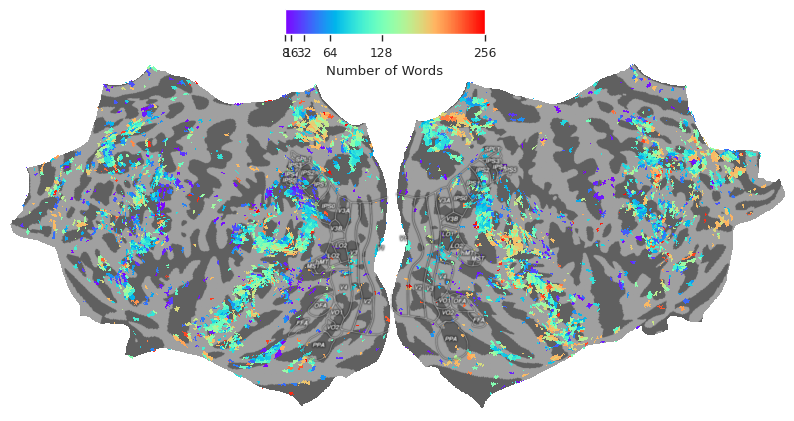

subject: COL, lang: zh
Background RRGGBBAA: ffffff00
Area 0:0:2274.66:1024 exported to 2275 x 1024 pixels (96 dpi)


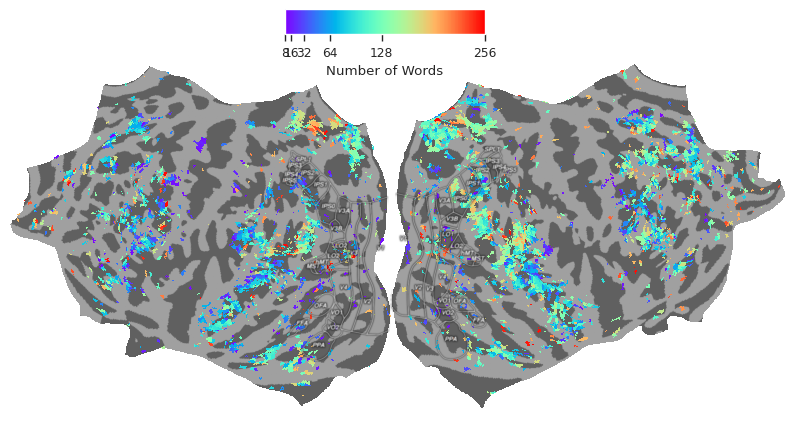

subject: GFW, lang: en
Background RRGGBBAA: ffffff00
Area 0:0:2274.66:1024 exported to 2275 x 1024 pixels (96 dpi)


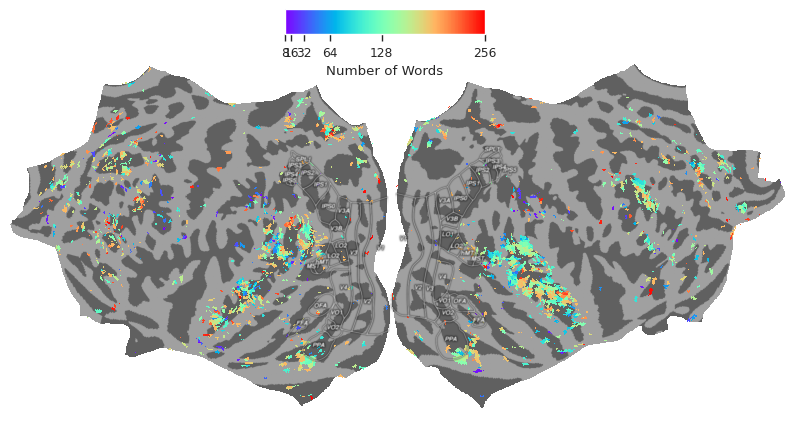

subject: GFW, lang: zh
Background RRGGBBAA: ffffff00
Area 0:0:2274.66:1024 exported to 2275 x 1024 pixels (96 dpi)


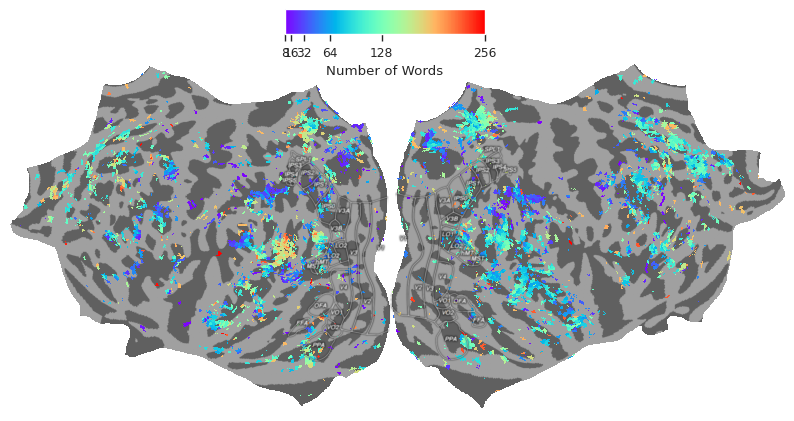

subject: TYE, lang: en
Background RRGGBBAA: ffffff00
Area 0:0:2274.66:1024 exported to 2275 x 1024 pixels (96 dpi)


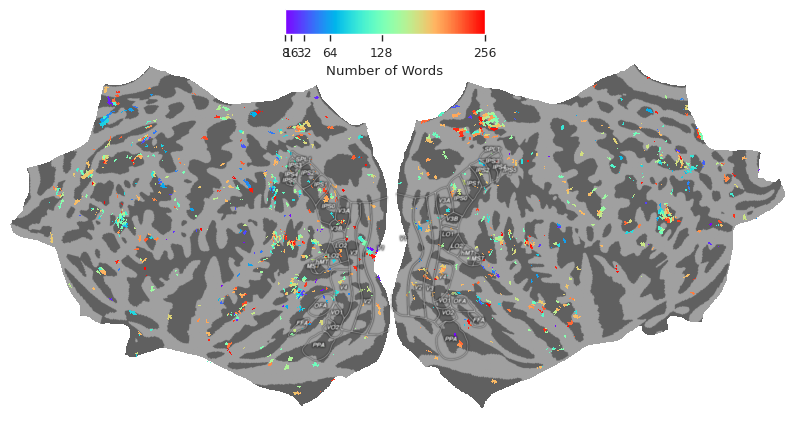

subject: TYE, lang: zh
Background RRGGBBAA: ffffff00
Area 0:0:2274.66:1024 exported to 2275 x 1024 pixels (96 dpi)


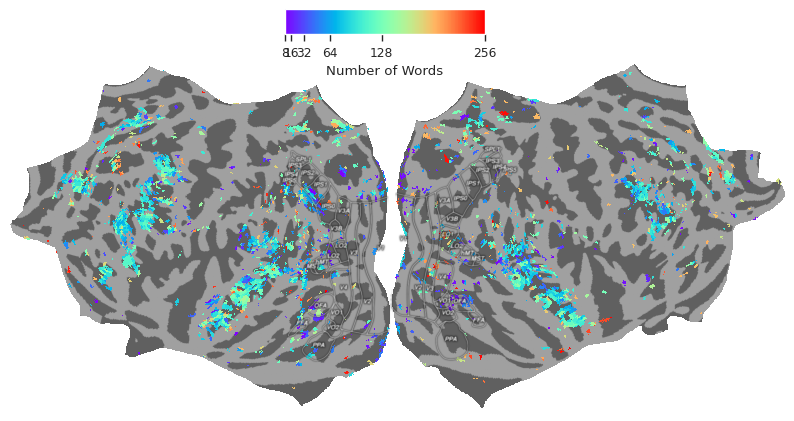

In [15]:
for subject_id in subjects_ids:

    lang = "en"
    data_en = timescale_data[subject_id][lang]
    # limit to 8-256, if not within range, set to np.nan
    data_en = np.where((data_en >= 8) & (data_en <= 256), data_en, np.nan)
    
    en_vertex = cortex.Vertex(data_en, fsaverage_surface, vmin=8, vmax=256, cmap="rainbow",)
    print(f"subject: {subject_id}, lang: {lang}")
    plot_flatmap_from_vertex(en_vertex, title=f"Timescale Selectivity of {subject_id} ({lang})",)
    plt.show()

    lang="zh"
    data_zh = timescale_data[subject_id][lang]
    # limit to 8-256, if not within range, set to np.nan
    data_zh = np.where((data_zh >= 8) & (data_zh <= 256), data_zh, np.nan)
    zh_vertex = cortex.Vertex(data_zh, fsaverage_surface, vmin=8, vmax=256, cmap="rainbow",)
    print(f"subject: {subject_id}, lang: {lang}")
    plot_flatmap_from_vertex(zh_vertex, title=f"Timescale Selectivity of {subject_id} ({lang})")
    plt.show()

# YEO's Parcelation

In [10]:
import nibabel as nib

In [11]:
areas_to_parcels_dict = {
    "DMN": ["DefaultA-Default_A", "DefaultB-Default_B", "DefaultC-Default_C"],
    "Control": ["ContA-Control_A", "ContB-Control_B", "ContC-Control_C"],
    "TempPar": ["TempPar-Temporal_Parietal"],
    "DorsAttn": ["DorsAttnA-Dorsal_Attention_A", "DorsAttnB-Dorsal_Attention_B"],
    "VentAttn": [
        "SalVentAttnA-Salience_Ventral_Attention_A",
        "SalVentAttnB-Salience_Ventral_Attention_B",
    ],
    "VisCent": ["VisCent-Visual_A", "VisPeri-Visual_B"],
    "SomMot": ["SomMotA-Somamotor_A", "SomMotB-Somamotor_B"],
    "Limbic": ["LimbicA-Limbic_A", "LimbicB-Limbic_B"],
}

colors_dict = {
    "DMN": "blue",
    "Control": "green",
    "TempPar": "red",
    "DorsAttn": "orange",
    "VentAttn": "purple",
    "VisCent": "brown",
    "SomMot": "pink",
    "Limbic": "gray",
}

annot_name_to_functional_name_dict = {
    17: {
        b"FreeSurfer_Defined_Medial_Wall_0": "FreeSurfer_Defined_Medial_Wall",
        b"17Networks_1": "VisCent-Visual_A",
        b"17Networks_2": "VisPeri-Visual_B",
        b"17Networks_3": "SomMotA-Somamotor_A",
        b"17Networks_4": "SomMotB-Somamotor_B",
        b"17Networks_5": "DorsAttnA-Dorsal_Attention_A",
        b"17Networks_6": "DorsAttnB-Dorsal_Attention_B",
        b"17Networks_7": "SalVentAttnA-Salience_Ventral_Attention_A",
        b"17Networks_8": "SalVentAttnB-Salience_Ventral_Attention_B",
        b"17Networks_9": "LimbicB-Limbic_B",
        b"17Networks_10": "LimbicA-Limbic_A",
        b"17Networks_11": "ContC-Control_C",
        b"17Networks_12": "ContA-Control_A",
        b"17Networks_13": "ContB-Control_B",
        b"17Networks_14": "TempPar-Temporal_Parietal",
        b"17Networks_15": "DefaultC-Default_C",
        b"17Networks_16": "DefaultA-Default_A",
        b"17Networks_17": "DefaultB-Default_B",
    },
    7: {
        b"FreeSurfer_Defined_Medial_Wall_0": "FreeSurfer_Defined_Medial_Wall",
        b"7Networks_1": "Visual",
        b"7Networks_2": "Somamotor",
        b"7Networks_3": "Dorsal attention",
        b"7Networks_4": "Ventral attention",
        b"7Networks_5": "Limbic",
        b"7Networks_6": "Frontoparietal",
        b"7Networks_7": "Default mode",
    },
}

In [12]:
lh_annot = nib.freesurfer.io.read_annot(
    os.path.join(yeos_label_dir, f"lh.Yeo2011_17Networks_N1000.annot")
)
rh_annot = nib.freesurfer.io.read_annot(
    os.path.join(yeos_label_dir, f"rh.Yeo2011_17Networks_N1000.annot")
)

num_fsaverage_vertices = 327684
num_networks = 17

lh_mask = np.arange(int(num_fsaverage_vertices // 2))
rh_mask = np.arange(int(num_fsaverage_vertices // 2), num_fsaverage_vertices)

In [13]:
functional_name_to_annot_indices_dict = {
    functional_name: int(str(annot_network_name).split("_")[-1].strip("'"))
    for annot_network_name, functional_name in annot_name_to_functional_name_dict[
        num_networks
    ].items()
}

area_name_to_annot_indices_dict = {
    area_name: [
        functional_name_to_annot_indices_dict[annot_network_name]
        for annot_network_name in annot_network_names
    ]
    for area_name, annot_network_names in areas_to_parcels_dict.items()
}

In [14]:
area_name_to_annot_indices_dict

{'DMN': [16, 17, 15],
 'Control': [12, 13, 11],
 'TempPar': [14],
 'DorsAttn': [5, 6],
 'VentAttn': [7, 8],
 'VisCent': [1, 2],
 'SomMot': [3, 4],
 'Limbic': [10, 9]}

In [19]:
# product of subject_ids, languages, timescale_ranges, areas_to_parcels_dict

from itertools import product

parcel_timescale = []

for subject_id, lang, area_name in product(
    subjects_ids, languages, areas_to_parcels_dict.keys()
):
    parcel_annot_indices = area_name_to_annot_indices_dict[area_name]
    parcel_included_vertices = np.array(
        list(
            set(
                list(lh_mask[np.where(np.isin(lh_annot[0], parcel_annot_indices))[0]])
                + list(rh_mask[np.where(np.isin(rh_annot[0], parcel_annot_indices))[0]])
            )
        )
    )

    # correlate timescale with parcel_mask
    data = timescale_data[subject_id][lang][parcel_included_vertices]

    parcel_timescale.append(
        {
            "subject_id": subject_id,
            "language": lang,
            "area": area_name,
            "timescale_selectivity": data,
        }
    )

In [20]:
parcel_timescale_df = pd.DataFrame(parcel_timescale)
parcel_timescale_df.head()

,subject_id,language,area,timescale_selectivity
0,COL,en,DMN,"[nan, nan, nan, nan, 185.15336607035184, nan, ..."
1,COL,en,Control,"[nan, 93.01822661423333, nan, 61.2711563049080..."
2,COL,en,TempPar,"[73.426925651837, nan, 104.42253874688197, nan..."
3,COL,en,DorsAttn,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
4,COL,en,VentAttn,"[nan, nan, nan, nan, 0.0, nan, nan, nan, 22.96..."


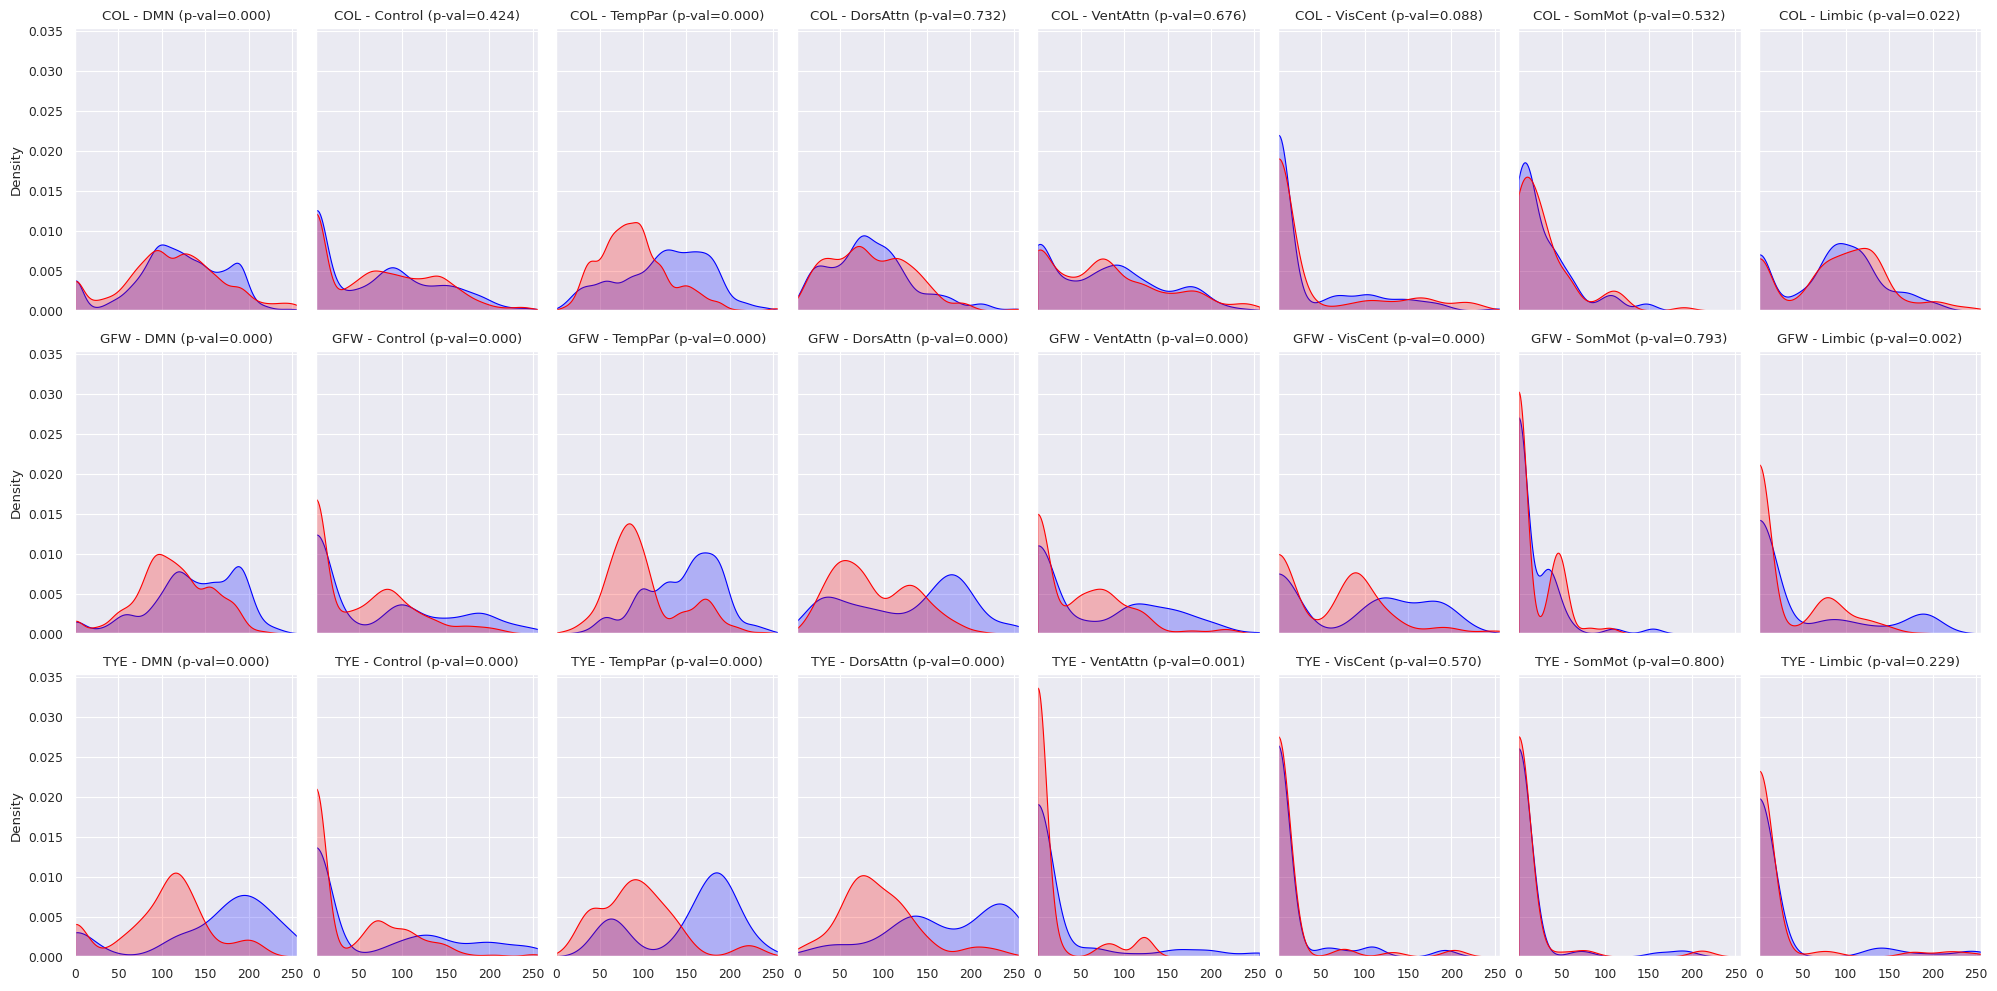

In [28]:
# now for each subject and language create a histogram 
fig, axs = plt.subplots(3, 8, figsize=(20, 10), sharex=True, sharey=True)

timescale_diff = []
for i, subject_id in enumerate(subjects_ids):
    for j, area_name in enumerate(areas_to_parcels_dict.keys()):
        # EN Histogram
        data_en = parcel_timescale_df[
            (parcel_timescale_df["subject_id"] == subject_id)
            & (parcel_timescale_df["language"] == 'en')
            & (parcel_timescale_df["area"] == area_name)
        ]["timescale_selectivity"].values[0]
        
        # ZH Histogram
        data_zh = parcel_timescale_df[
            (parcel_timescale_df["subject_id"] == subject_id)
            & (parcel_timescale_df["language"] == 'zh')
            & (parcel_timescale_df["area"] == area_name)
        ]["timescale_selectivity"].values[0]
        
        valid_en_voxel = np.where(~np.isnan(data_en))[0]
        valid_zh_voxel = np.where(~np.isnan(data_zh))[0]
        
        shared_voxel = np.intersect1d(valid_en_voxel, valid_zh_voxel)   
        
        data_en = data_en[shared_voxel]
        data_zh = data_zh[shared_voxel]
        
        assert len(data_en) == len(data_zh)
        
        #pval,_ = two_side_ks_test(data_en, data_zh)
        pval, _ = timescale_permutation_test(data_en, data_zh, perm_func, num_permutations=10000)
    
        # diff
        diff = data_en - data_zh

        timescale_diff.append(
            {
                "subject_id": subject_id,
                "area": area_name,
                "diff": diff,
                "pval": pval,
            }
        )

        sns.kdeplot(data_en, color="blue", label="EN", fill=True, ax=axs[i, j], clip=(0, 256))
        sns.kdeplot(data_zh, color="red", label="ZH", fill=True, ax=axs[i, j], clip=(0, 256))
        
        # sns.histplot(data_en, color="blue", label="EN", ax=axs[i, j], kde=True, bins=16, stat="density", alpha=0.2, clip=(0, 256))   
        # sns.histplot(data_zh, color="red", label="ZH", ax=axs[i, j], kde=True, bins=16, stat="density", alpha=0.2, clip=(0, 256))
        #sns.kdeplot(diff, color="green", label="Diff", fill=True, ax=axs[i, j])
        
        axs[i, j].set_title(f"{subject_id} - {area_name} (p-val={pval:.3f})")
        axs[i, j].set_xlim(0, 256)
        
plt.tight_layout()
plt.show()

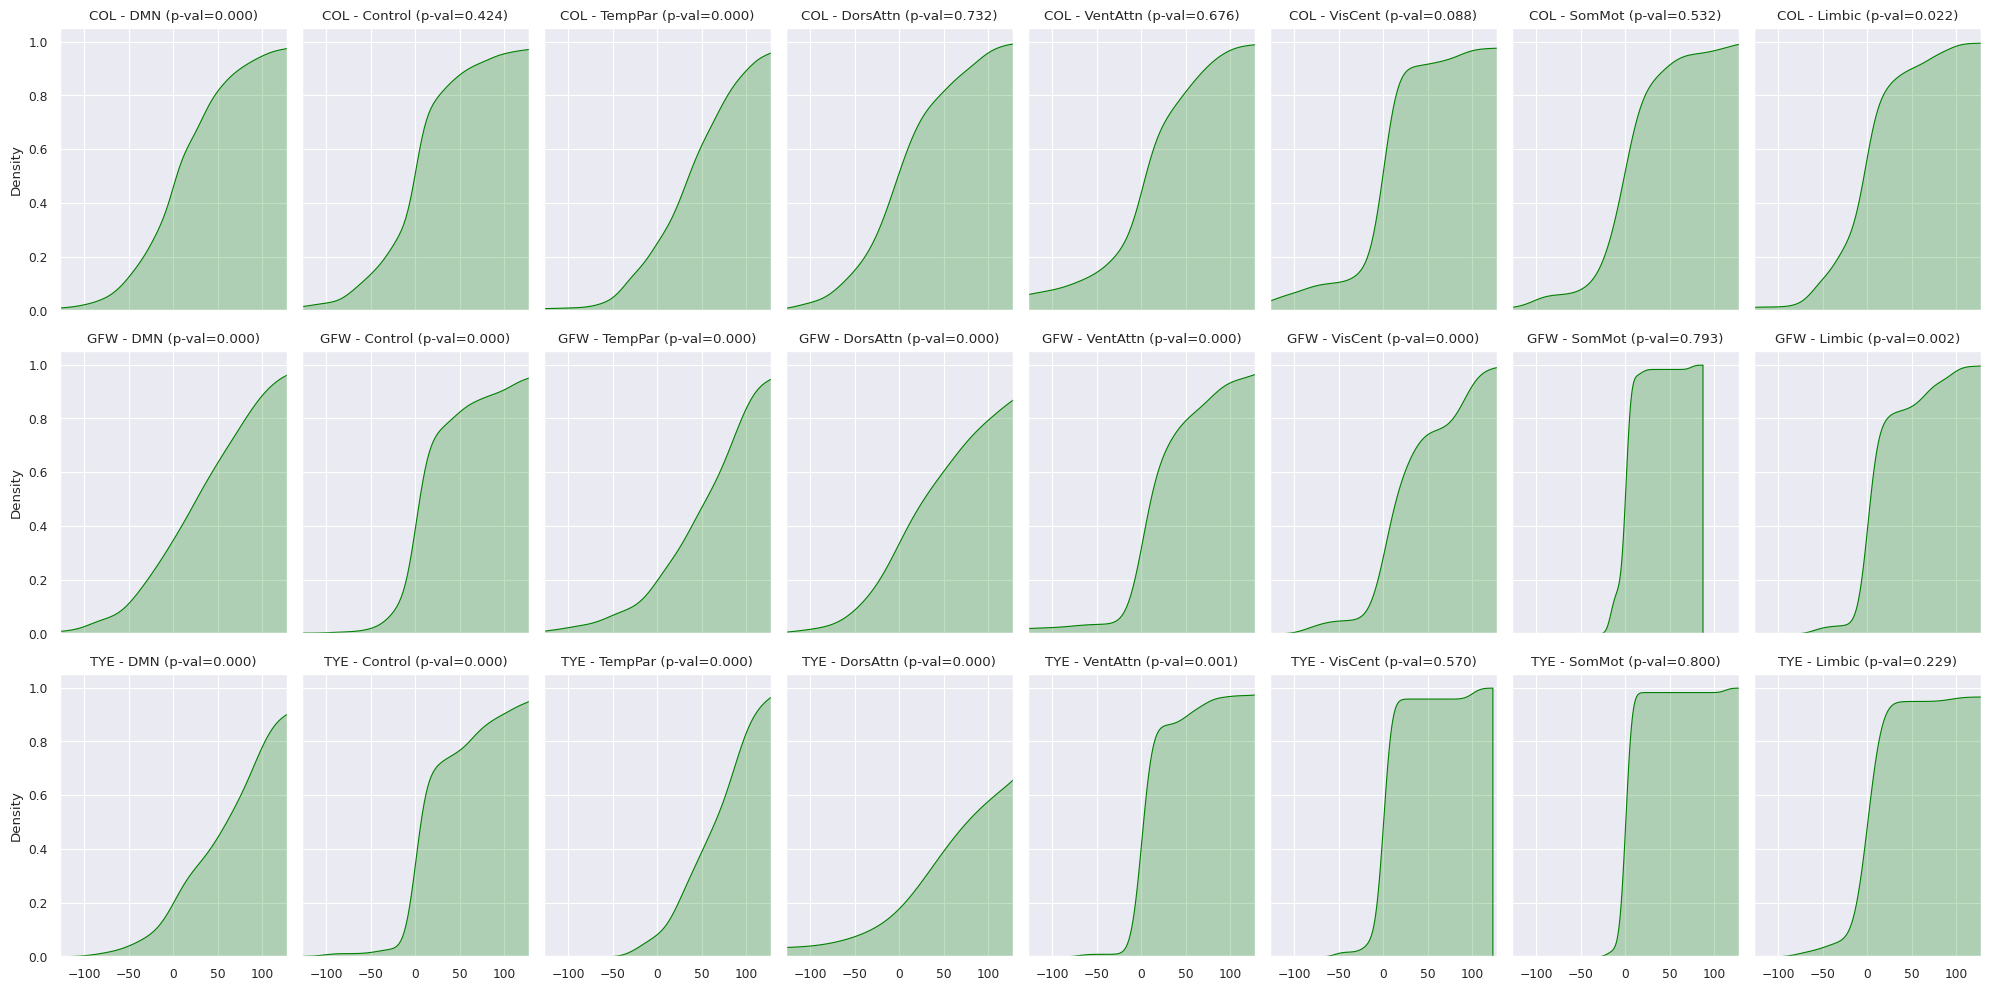

In [30]:
timescale_diff_df = pd.DataFrame(timescale_diff)

fig, axs = plt.subplots(3, 8, figsize=(20, 10), sharex=True, sharey=True)

for i, subject_id in enumerate(subjects_ids):
    for j, area_name in enumerate(areas_to_parcels_dict.keys()):
        cur_data = timescale_diff_df[
            (timescale_diff_df["subject_id"] == subject_id)
            & (timescale_diff_df["area"] == area_name)
        ]
        
        diff = cur_data["diff"].values[0]
        pval = cur_data["pval"].values[0]
        
        sns.kdeplot(diff, color="green", label="Diff", fill=True, ax=axs[i, j], cumulative=True) 
                
        axs[i, j].set_title(f"{subject_id} - {area_name} (p-val={pval:.3f})")
        axs[i, j].set_xlim(-128, 128)
        
plt.tight_layout()
plt.show()

# Plotting the Yeo's parcelation of the brain

In [31]:
# get parcel_included_vertices for each area

parcel_indices_dict = {}

for area_name in areas_to_parcels_dict.keys():
    parcel_indices = area_name_to_annot_indices_dict[area_name]
    parcel_included_vertices = np.array(
        list(
            set(
                list(lh_mask[np.where(np.isin(lh_annot[0], parcel_indices))[0]])
                + list(rh_mask[np.where(np.isin(rh_annot[0], parcel_indices))[0]])
            )
        )
    )
    parcel_indices_dict[area_name] = parcel_included_vertices

In [32]:
# get rgb value from area color
from matplotlib.colors import to_rgb

area_rgb_dict = {
    area_name: to_rgb(colors_dict[area_name]) for area_name in colors_dict.keys()
}

In [33]:
# create zero valued array and then fill in the values
data_r = np.zeros(num_fsaverage_vertices, dtype=int)
data_g = np.zeros(num_fsaverage_vertices, dtype=int)
data_b = np.zeros(num_fsaverage_vertices, dtype=int)

for area_name in areas_to_parcels_dict.keys():
    parcel_included_vertices = parcel_indices_dict[area_name]
    r, g, b = area_rgb_dict[area_name]

    data_r[parcel_included_vertices] = int(r*255)
    data_g[parcel_included_vertices] = int(g*255)
    data_b[parcel_included_vertices] = int(b*255)

In [34]:
from cortex import VertexRGB, Vertex
from cortex.quickflat import make_figure
import matplotlib.patches as mpatches

In [35]:
red = Vertex(data_r, fsaverage_surface)
green = Vertex(data_g, fsaverage_surface)   
blue = Vertex(data_b, fsaverage_surface)

vertex_rgb = VertexRGB(red, green, blue, fsaverage_surface)

Background RRGGBBAA: ffffff00
Area 0:0:2274.66:1024 exported to 2275 x 1024 pixels (96 dpi)


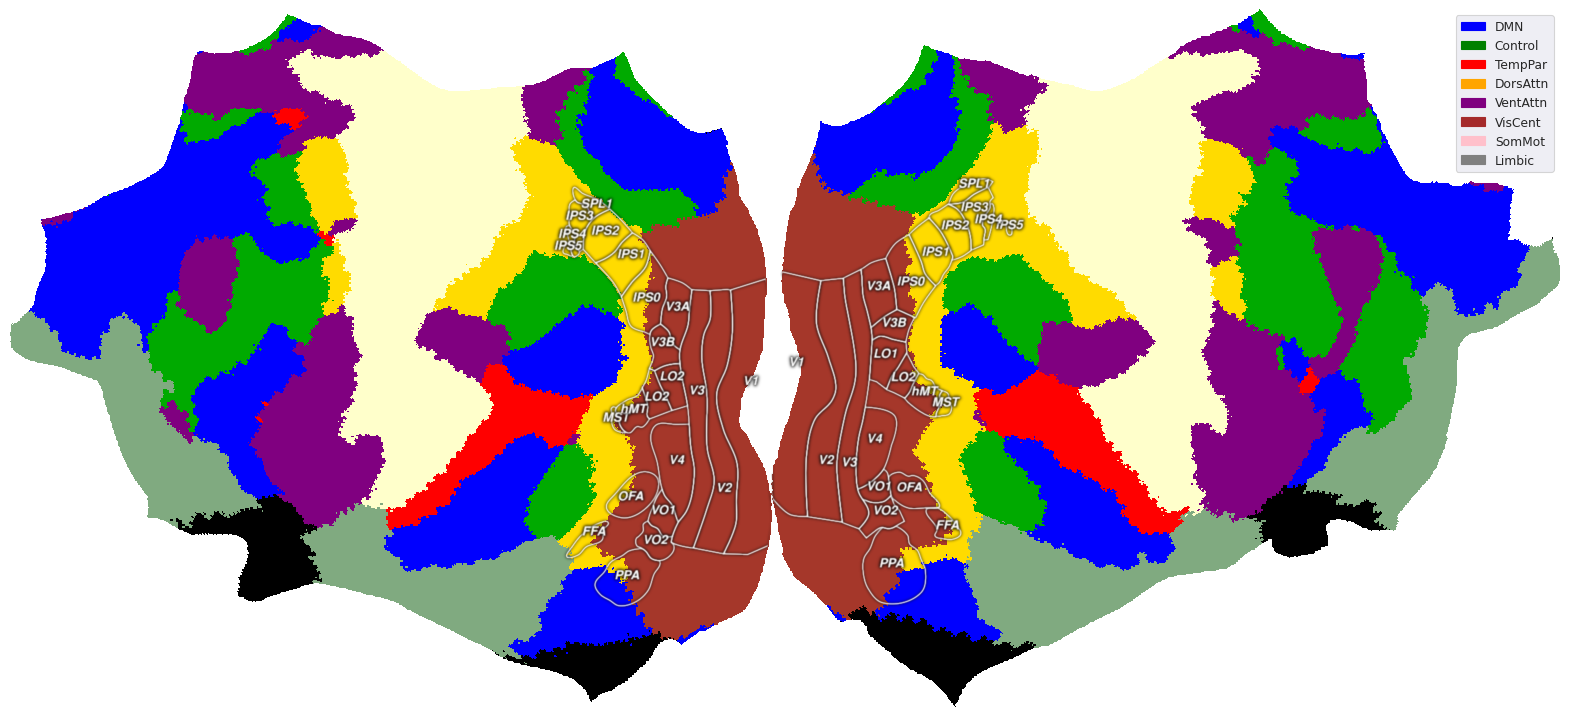

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))


make_figure(
        vertex_rgb,
        fig=ax,
        with_colorbar=False,
        with_curvature=True,
        nanmean=True,
    )

ax.axis("off")
# add color legend

patches = []
for area_name, rgb in area_rgb_dict.items():
    #patch = mpatches.Patch(color=rgb, label=area_name)
    patches.append(mpatches.Patch(color=rgb, label=area_name))
ax.legend(handles=patches, loc="upper right")
    

In [27]:
parcel_timescale_df

,subject_id,language,area,timescale_selectivity
0,COL,en,DMN,"[nan, nan, nan, nan, 185.15336607035184, nan, ..."
1,COL,en,Control,"[nan, 93.01822661423333, nan, 61.2711563049080..."
2,COL,en,TempPar,"[73.426925651837, nan, 104.42253874688197, nan..."
3,COL,en,DorsAttn,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
4,COL,en,VentAttn,"[nan, nan, nan, nan, 0.0, nan, nan, nan, 22.96..."
5,COL,en,VisCent,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
6,COL,en,SomMot,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
7,COL,en,Limbic,"[12.601289747885378, nan, nan, nan, nan, nan, ..."
8,COL,zh,DMN,"[nan, nan, nan, 250.77265927668054, nan, nan, ..."
9,COL,zh,Control,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."


In [26]:
# # now create heatmap for subject and language
# data_avg_en = np.zeros(
#     (len(timescale_ranges.keys()), len(areas_to_parcels_dict.keys()))
# )
# data_avg_zh = np.zeros(
#     (len(timescale_ranges.keys()), len(areas_to_parcels_dict.keys()))
# )

# for subject_id, lang in product(subjects_ids, languages):
#     data_df = parcel_timescale_df[parcel_timescale_df["subject_id"] == subject_id]
#     data_df = data_df[data_df["language"] == lang]

#     # drop subject and language columns
#     data_df = data_df.pivot(index="timescale", columns="area", values="correlation")
#     # rearange index to timescale_ranges
#     data_df = data_df.reindex(index=timescale_ranges.keys())

#     # add to data_avg
#     if lang == "en":
#         data_avg_en += data_df.values
#     else:
#         data_avg_zh += data_df.values
#     # plot heatmap
#     sns.heatmap(data_df, annot=True, vmin=0, vmax=0.2, fmt=".2f")
#     # xticks tilt
#     plt.xticks(rotation=45)
#     plt.title(f"{subject_id} ({lang})")
#     plt.show()


# x_tick_labels = sorted(list(areas_to_parcels_dict.keys()))
# # plot average en
# data_avg_en /= len(subjects_ids) * len(languages)
# sns.heatmap(data_avg_en, annot=True, vmin=0, vmax=0.2, fmt=".2f")
# plt.xticks(np.arange(len(areas_to_parcels_dict.keys())) + 0.5, x_tick_labels)
# plt.xticks(rotation=45)
# plt.yticks(np.arange(len(timescale_ranges.keys())) + 0.5, timescale_ranges.keys())
# plt.yticks(rotation=0)
# plt.title("Average EN")
# plt.show()

# # plot average ZH
# data_avg_zh /= len(subjects_ids) * len(languages)
# sns.heatmap(data_avg_zh, annot=True, vmin=0, vmax=0.2, fmt=".2f")
# plt.xticks(np.arange(len(areas_to_parcels_dict.keys())) + 0.5, x_tick_labels)
# plt.xticks(rotation=45)
# plt.yticks(np.arange(len(timescale_ranges.keys())) + 0.5, timescale_ranges.keys())
# plt.yticks(rotation=0)
# plt.title("Average ZH")


# plt.show()

KeyError: 'timescale'